<a href="https://colab.research.google.com/github/sharonct/PythonInvest/blob/main/trading_strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trading Strategies Project**

## Overview

The project aims to explore and evaluate different trading strategies using historical price data of Amazon (AMZN) stock. It leverages the Backtrader library, a popular Python framework for backtesting and trading strategy development. **The main objective is to explore different trading strategies and compare their performance through backtesting.**

## Key Components
**Strategy Development:** Several trading strategies are implemented as classes inheriting from the `bt.Strategy` class provided by Backtrader. These strategies include:
  - Moving Average Crossover
  - Exponential Moving Average (EMA) Crossover
  - RSI Mean Reversion

**Parameter Optimization:** A grid search approach is employed to find optimal parameters for the trading strategies. This involves iterating over different combinations of strategy parameters and selecting the parameters that yield the highest returns.

**Backtesting:** The strategies are backtested using historical data to evaluate their performance over a specified period. Backtrader is used to simulate trading based on the defined strategies and parameters.

**Performance Evaluation:** Various performance metrics, such as initial and final portfolio values, percentage returns, and average returns, are calculated to assess the effectiveness of each strategy.

**Visualization:** The performance of each strategy is visualized using candlestick charts, providing insights into the trading signals generated and the resulting portfolio value changes over time.



In [3]:
## Install necessary libraries

!pip install backtrader


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 3.0 MB/s eta 0:00:00


In [4]:
import backtrader as bt
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import itertools

%matplotlib inline


### Helper function to run strategies and plot candlestick charts

In [5]:
ticker = 'AMZN'

In [6]:
def run_strategy(ticker,strategy,plot_candlestick=True):
  # Create a cerebro engine
  cerebro = bt.Cerebro()

  # Add data feed
  data = bt.feeds.PandasData(dataname=yf.download(ticker, '2023-01-01', '2024-01-01', auto_adjust=True))
  cerebro.adddata(data)

  # Add the strategy
  cerebro.addstrategy(strategy)

  # Run the strategy
  cerebro.run()

  # Print the initial portfolio value
  initial_portfolio_value = cerebro.broker.startingcash
  print('Initial Portfolio Value: %.2f' % initial_portfolio_value)

  # Print the final portfolio value
  final_portfolio_value = cerebro.broker.getvalue()
  print('Final Portfolio Value: %.2f' % final_portfolio_value)

  # Calculate the percentage return
  percentage_return = ((final_portfolio_value - initial_portfolio_value) / initial_portfolio_value) * 100

  # Get the strategy name
  strategy_name = cerebro.runstrats[0][0].params.name

  print(f"{strategy_name} Percentage Return : {percentage_return}")

  # Plot the candlestick chart if required
  if plot_candlestick:
      cerebro.plot(style='candlestick', barup='green', bardown='red', iplot=False, volume=False)

  return percentage_return



## Benchmark: Buy and Hold Strategy

This code block implements a simple buy and hold strategy as a benchmark for comparison with the other more sophisticated strategies.

**Strategy Description:**

The `BuyAndHold` strategy buys the asset (in this case, Amazon stock) at the beginning of the backtest period and holds it until the end without any selling conditions.


[*********************100%%**********************]  1 of 1 completed


Initial Portfolio Value: 10000.00
Final Portfolio Value: 10065.39
BuyAndHold Percentage Return : 0.6538999938964843


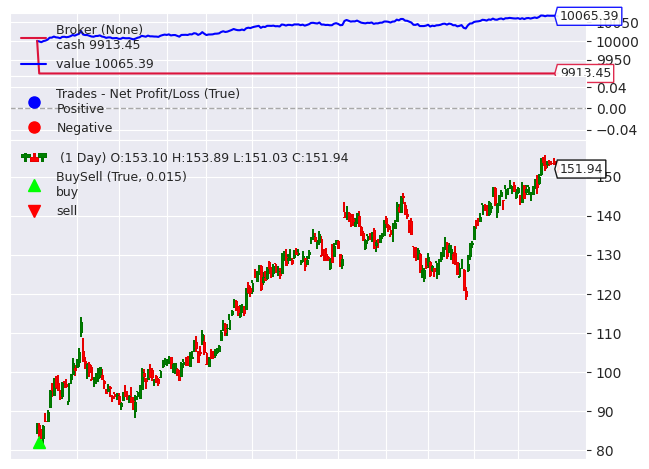

0.6538999938964843

In [7]:
## Benchmark

class BuyAndHold(bt.Strategy):
    params = (
        ('name', 'BuyAndHold'),
    )

    def __init__(self):
        pass

    def next(self):
        if not self.position:
            self.buy()


run_strategy(ticker, BuyAndHold)

## MA Crossover Strategy


**Strategy Description:**

We define a moving average crossover strategy with two moving averages: a fast moving average with a short period and a slow moving average with a longer period. When the fast moving average crosses above the slow moving average, it generates a buy signal, indicating a potential uptrend. Conversely, when the fast moving average crosses below the slow moving average, it generates a sell signal, indicating a potential downtrend.



[*********************100%%**********************]  1 of 1 completed


Initial Portfolio Value: 10000.00
Final Portfolio Value: 10049.77
MA Crossover Percentage Return : 0.49769981384277345


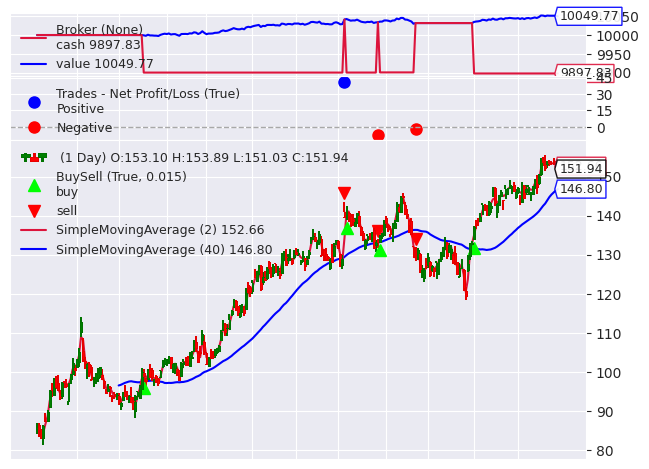

0.49769981384277345

In [8]:
class MA_Crossover(bt.Strategy):
    params = (
        ('name', 'MA Crossover'),
        ('fast_period', 2),
        ('slow_period', 40),
    )

    def __init__(self):
        # Add indicators
        self.fast_ma = bt.indicators.SimpleMovingAverage(self.data, period=self.params.fast_period)
        self.slow_ma = bt.indicators.SimpleMovingAverage(self.data, period=self.params.slow_period)

    def next(self):
        # Check for a crossover
        if self.fast_ma[0] > self.slow_ma[0] and self.fast_ma[-1] <= self.slow_ma[-1]:
            self.buy()
        elif self.fast_ma[0] < self.slow_ma[0] and self.fast_ma[-1] >= self.slow_ma[-1]:
            self.sell()


run_strategy(ticker, MA_Crossover)

**Strategy Optimization:**

The section creates a function that conducts a grid search over specified ranges of `fast_period` (short moving average period) and `slow_period` (long moving average period). It iterates over all combinations of these parameters, running the strategy for each combination. After evaluating the returns, it identifies the combination of parameters that yields the highest return.


In [9]:
def strategy_optimization(ticker, strategy):
  # Create a cerebro engine
  cerebro = bt.Cerebro()

  # Add data feed
  data = bt.feeds.PandasData(dataname=yf.download(ticker, '2023-01-01', '2024-01-01', auto_adjust=True))
  cerebro.adddata(data)

  # Define a range of values for fast and slow periods
  fast_period_range = range(2, 21)
  slow_period_range = range(30, 201, 10)
  best_return = -float('inf')
  best_params = {}

  # Iterate over all combinations
  for fast_period, slow_period in itertools.product(fast_period_range, slow_period_range):
      # Create a new instance of Cerebro for each combination
      cerebro = bt.Cerebro()

      # Add data feed
      cerebro.adddata(data)

      # Add the strategy with current parameters
      cerebro.addstrategy(strategy, fast_period=fast_period, slow_period=slow_period)

      # Run the strategy
      cerebro.run()

      # Calculate the returns
      final_portfolio_value = cerebro.broker.getvalue()
      initial_portfolio_value = cerebro.broker.startingcash
      returns = ((final_portfolio_value - initial_portfolio_value) / initial_portfolio_value) * 100

      # Check if this combination yields better returns
      if returns > best_return:
          best_return = returns
          best_params['fast_period'] = fast_period
          best_params['slow_period'] = slow_period

  print("Best Parameters:", best_params)
  print("Best Return:", best_return)

In [10]:
strategy_optimization(ticker, MA_Crossover)

[*********************100%%**********************]  1 of 1 completed


Best Parameters: {'fast_period': 2, 'slow_period': 40}
Best Return: 0.49769981384277345


## Exponential Moving Average (EMA) Crossover Strategy

Similar to the simple moving average (SMA) crossover strategy, the `EMA_Crossover` generates buy and sell signals based on the crossover of two EMAs: a fast EMA with a short period and a slow EMA with a longer period.

This strategy provides a more responsive trading signal compared to the simple moving average crossover strategy, potentially leading to improved performance in capturing shorter-term trends.


[*********************100%%**********************]  1 of 1 completed

Initial Portfolio Value: 10000.00
Final Portfolio Value: 10051.77
EMA_Crossover Percentage Return : 0.5177000427246093


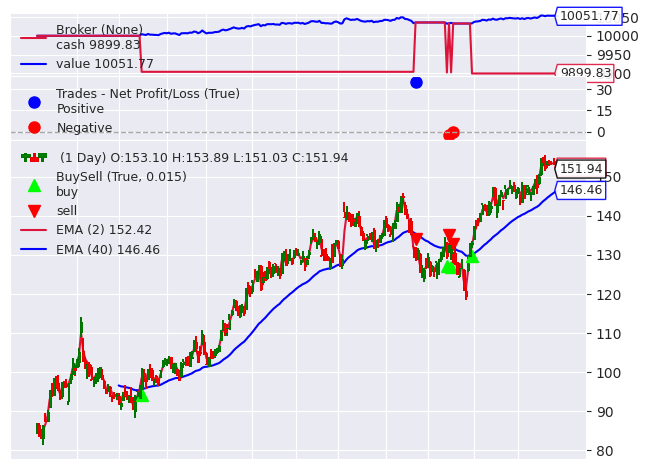

0.5177000427246093

In [11]:
class EMA_Crossover(bt.Strategy):
    params = (
        ('name', 'EMA_Crossover'),
        ('fast_period', 2),
        ('slow_period', 40),
    )

    def __init__(self):
        self.fast_ema = bt.indicators.EMA(self.data.close, period=self.params.fast_period)
        self.slow_ema = bt.indicators.EMA(self.data.close, period=self.params.slow_period)

    def next(self):
        # Buy signal: Fast EMA crosses above slow EMA
        if self.fast_ema > self.slow_ema and self.fast_ema[-1] <= self.slow_ema[-1]:
            self.buy()
        # Sell signal: Fast EMA crosses below slow EMA
        elif self.fast_ema < self.slow_ema and self.fast_ema[-1] >= self.slow_ema[-1]:
            self.sell()

run_strategy(ticker, EMA_Crossover)

In [12]:
strategy_optimization(ticker,EMA_Crossover)

[*********************100%%**********************]  1 of 1 completed


Best Parameters: {'fast_period': 2, 'slow_period': 40}
Best Return: 0.5177000427246093


## RSI Mean Reversion Strategy

The `RSI_MeanReversion` class defines a mean reversion strategy based on the RSI indicator. It uses a 14-period RSI to identify overbought and oversold conditions. When the RSI falls below the oversold threshold (30 by default), it generates a buy signal, indicating a potential reversal to the upside. Conversely, when the RSI rises above the overbought threshold (70 by default), it generates a sell signal, indicating a potential reversal to the downside.

This strategy aims to profit from short-term price reversals observed when the RSI reaches extreme levels, thus providing a potential edge in trading.


[*********************100%%**********************]  1 of 1 completed


Initial Portfolio Value: 10000.00
Final Portfolio Value: 10927.61
RSI_MeanReversion Percentage Return : 9.276100463867188


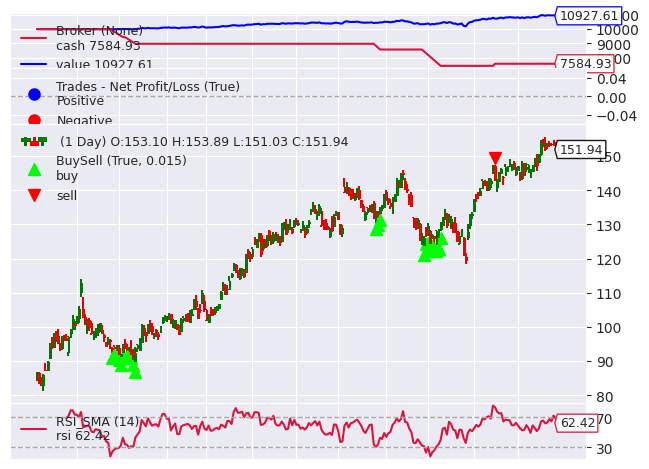

9.276100463867188

In [13]:
class RSI_MeanReversion(bt.Strategy):
    params = (
        ('name', 'RSI_MeanReversion'),
        ('overbought', 85),  # RSI value for overbought condition
        ('oversold', 35),     # RSI value for oversold condition
    )

    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=14)  # 14-period RSI
        self.avg_return = []

    def next(self):
        if self.rsi < self.params.oversold:
            self.buy()   # Buy when RSI is below the oversold threshold
        elif self.rsi > self.params.overbought:
            self.sell()  # Sell when RSI is above the overbought threshold

    def notify_trade(self, trade):
        if trade.isclosed:
            self.avg_return.append(trade.pnl)

run_strategy(ticker, RSI_MeanReversion)


In [14]:
# Create a cerebro engine
cerebro = bt.Cerebro()

# Add data feed
data = bt.feeds.PandasData(dataname=yf.download(ticker, '2023-01-01', '2024-01-01', auto_adjust=True))
cerebro.adddata(data)

# Define a range of values for overbought and oversold thresholds
overbought_range = range(70, 90, 5)
oversold_range = range(20, 40, 5)

best_return = -float('inf')
best_params = {}

# Iterate over all combinations
for overbought, oversold in itertools.product(overbought_range, oversold_range):
    # Create a new instance of Cerebro for each combination
    cerebro = bt.Cerebro()

    # Add data feed
    cerebro.adddata(data)

    # Add the strategy with current parameters
    cerebro.addstrategy(RSI_MeanReversion, overbought=overbought, oversold=oversold)

    # Run the strategy
    cerebro.run()

    # Calculate the returns
    final_portfolio_value = cerebro.broker.getvalue()
    initial_portfolio_value = cerebro.broker.startingcash
    returns = ((final_portfolio_value - initial_portfolio_value) / initial_portfolio_value) * 100

    # Check if this combination yields better returns
    if returns > best_return:
        best_return = returns
        best_params['overbought'] = overbought
        best_params['oversold'] = oversold

print("Best Parameters:", best_params)
print("Best Return:", best_return)

[*********************100%%**********************]  1 of 1 completed


Best Parameters: {'overbought': 85, 'oversold': 35}
Best Return: 9.276100463867188


## Variable Trend Strategy
    
This strategy aims to capitalize on variable trends in the market by detecting consecutive days of price increase or decrease.
It generates buy signals when the price increases for a specified number of consecutive days and sell signals when the price decreases for another specified number of consecutive days.

**Parameters:**
- `consecutive_buy_days` (int, default: 2): Number of consecutive days of price increase required for a buy signal.
- `consecutive_sell_days` (int, default: 4): Number of consecutive days of price decrease required for a sell signal.

**Strategy Logic:**
1. Determine the market trend based on the comparison of the current close price with the previous close price.
2. Count consecutive days of price increase or decrease.
3. Generate buy signals if the price increases for `consecutive_buy_days` days and there is no open position.
4. Generate sell signals if the price decreases for `consecutive_sell_days` days and there is an existing long position.
    

[*********************100%%**********************]  1 of 1 completed


Initial Portfolio Value: 10000.00
Final Portfolio Value: 10064.91
VariableTrend Percentage Return : 0.6491000366210937


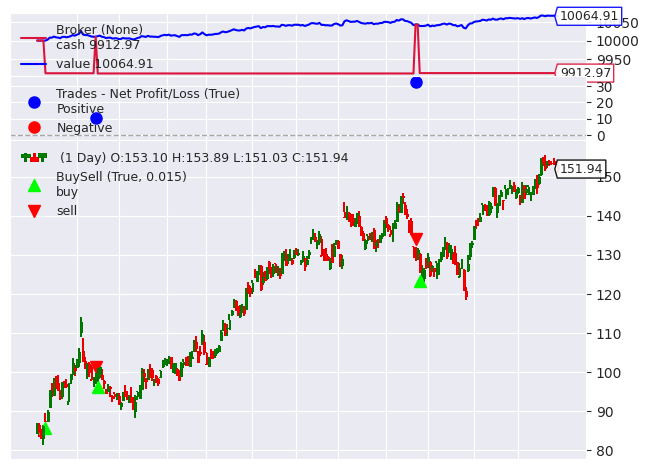

0.6491000366210937

In [16]:
class VariableTrend(bt.Strategy):
    params = (
        ('name', 'VariableTrend'),
        ('consecutive_buy_days', 1),  # Days for buy signal
        ('consecutive_sell_days', 6),  # Days for sell signal
    )

    def __init__(self):
        self.trend_up = False
        self.trend_down = False
        self.up_count = 0
        self.down_count = 0
        self.prev_close = None

    def next(self):  # Pass data as an argument
        if self.prev_close is None:
            self.prev_close = self.data.close[0]
            return

        # Determine market trend
        trend_up = self.data.close[0] > self.prev_close
        trend_down = self.data.close[0] < self.prev_close

        # Check for trend continuation or reversal
        if trend_up:
            self.up_count += 1
            self.down_count = 0
        elif trend_down:
            self.up_count = 0
            self.down_count += 1

        # Check for buy signal
        if trend_up and self.up_count >= self.params.consecutive_buy_days and self.position.size == 0:  # Check for no open position
            self.buy()

        # Check for sell signal (trend continuation down after sell_days):
        elif trend_down and self.down_count >= self.params.consecutive_sell_days and self.position.size > 0:
            self.sell()


        self.prev_close = self.data.close[0]

run_strategy(ticker, VariableTrend)

## Grid Search for Optimal Parameters

This code block conducts a grid search to find the optimal combination of parameters for the `VariableTrend` strategy. It iterates over various values of `consecutive_buy_days` and `consecutive_sell_days`, running the strategy for each combination. After evaluating the returns, it identifies the combination that yields the highest return.


This grid search approach helps in identifying parameter combinations that maximize returns for the `VariableTrend` strategy.


In [17]:
# Define a range of values for consecutive_buy_days and consecutive_sell_days
buy_days_range = range(1, 10)
sell_days_range = range(1, 10)

best_return = -float('inf')
best_params = {}

# Iterate over all combinations
for buy_days, sell_days in itertools.product(buy_days_range, sell_days_range):
    # Create a new instance of Cerebro for each combination
    cerebro = bt.Cerebro()

    # Add data feed
    cerebro.adddata(data)

    # Add the VariableTrend strategy with current parameters
    cerebro.addstrategy(VariableTrend, consecutive_buy_days=buy_days, consecutive_sell_days=sell_days)

    # Run the strategy
    cerebro.run()

    # Calculate the returns
    final_portfolio_value = cerebro.broker.getvalue()
    initial_portfolio_value = cerebro.broker.startingcash
    returns = ((final_portfolio_value - initial_portfolio_value) / initial_portfolio_value) * 100

    # Check if this combination yields better returns
    if returns > best_return:
        best_return = returns
        best_params['consecutive_buy_days'] = buy_days
        best_params['consecutive_sell_days'] = sell_days

print("Best Parameters:", best_params)
print("Best Return:", best_return)


Best Parameters: {'consecutive_buy_days': 2, 'consecutive_sell_days': 4}
Best Return: 0.7577001953125


## Comparing Different Strategies

In [18]:
%%capture

# Define the performance metrics for each strategy
strategies = ['Buy And Hold','Moving Average Crossover', 'EMA Crossover', 'RSI Mean Reversion', 'Variable Trend']
returns = [run_strategy(ticker, BuyAndHold, False),run_strategy(ticker, MA_Crossover,False), run_strategy(ticker, EMA_Crossover,False), run_strategy(ticker, RSI_MeanReversion,False),run_strategy(ticker, VariableTrend,False)]



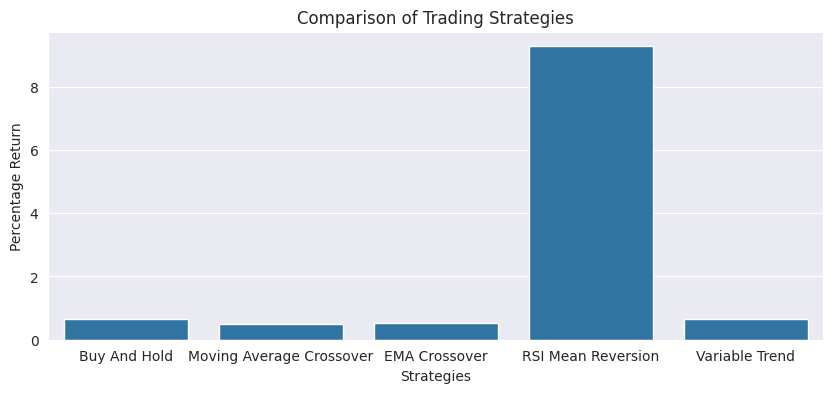

In [19]:
sns.set_style("darkgrid")

# Create the bar chart using Seaborn
plt.figure(figsize=(10, 4))
sns.barplot(x=strategies, y=returns)
plt.xlabel('Strategies')
plt.ylabel('Percentage Return')
plt.title('Comparison of Trading Strategies')

# Show the plot
plt.show()

The **RSI Mean Reversion** strategy yielded the highest percentage return of approximately **9.28%**. This indicates that it was the most profitable strategy during the testing period. The trend following strategies performed slightly worse compared to the baseline buy and hold model.